In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict, Counter
import random
import json
import warnings
import time
warnings.filterwarnings('ignore')

In [3]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Global data storage
daily_events = defaultdict(list)
event_history = []
session_start_time = datetime.now()

# Configuration
threat_keywords = {
    'high_threat': ['shooting', 'assault', 'fighting', 'abuse', 'explosion', 'arson', 'weapon', 'violence'],
    'medium_threat': ['robbery', 'burglary', 'stealing', 'shoplifting', 'vandalism', 'trespassing'],
    'crowd_related': ['crowd', 'density', 'gathering', 'overcrowding', 'stampede']
}

In [4]:
def initialize_system():
    """Initialize or reset the system"""
    global daily_events, event_history, session_start_time
    daily_events = defaultdict(list)
    event_history = []
    session_start_time = datetime.now()
    print("✅ NLP Report Generator system initialized!")

In [5]:
def log_event(event_type, details, timestamp=None):
    """Log events for daily report generation"""
    global daily_events, event_history

    if timestamp is None:
        timestamp = datetime.now()

    event_data = {
        'timestamp': timestamp,
        'type': event_type,
        'details': details,
        'hour': timestamp.hour,
        'date': timestamp.strftime('%Y-%m-%d')
    }

    date_key = timestamp.strftime('%Y-%m-%d')
    daily_events[date_key].append(event_data)
    event_history.append(event_data)

In [6]:
def get_threat_level(details):
    """Determine threat level of an event"""
    details_lower = details.lower()

    if any(keyword in details_lower for keyword in threat_keywords['high_threat']):
        return 'high'
    elif any(keyword in details_lower for keyword in threat_keywords['medium_threat']):
        return 'medium'
    else:
        return 'low'

In [7]:
def analyze_events(events):
    """Analyze events and extract patterns"""
    analysis = {
        'total_events': len(events),
        'threat_levels': {'high': 0, 'medium': 0, 'low': 0},
        'hourly_distribution': defaultdict(int),
        'event_types': Counter(),
        'peak_hours': [],
        'threat_summary': [],
        'crowd_events': 0,
        'duration_minutes': 0
    }

    # Calculate session duration
    if events:
        start_time = min(event['timestamp'] for event in events)
        end_time = max(event['timestamp'] for event in events)
        analysis['duration_minutes'] = int((end_time - start_time).total_seconds() / 60)

    for event in events:
        # Categorize threat level
        threat_level = get_threat_level(event['details'])
        analysis['threat_levels'][threat_level] += 1

        if threat_level in ['high', 'medium']:
            analysis['threat_summary'].append(
                f"{threat_level.capitalize()} threat: {event['details']} at {event['timestamp'].strftime('%H:%M')}")

        # Track crowd events
        if any(keyword in event['details'].lower() for keyword in threat_keywords['crowd_related']):
            analysis['crowd_events'] += 1

        # Hourly distribution
        analysis['hourly_distribution'][event['hour']] += 1

        # Event types
        analysis['event_types'][event['type']] += 1

    # Find peak hours
    if analysis['hourly_distribution']:
        max_events = max(analysis['hourly_distribution'].values())
        analysis['peak_hours'] = [hour for hour, count in analysis['hourly_distribution'].items()
                                  if count == max_events]

    return analysis

In [8]:
def generate_recommendations(analysis):
    """Generate contextual recommendations based on analysis"""
    recommendations = []

    high_threats = analysis['threat_levels']['high']
    medium_threats = analysis['threat_levels']['medium']
    crowd_events = analysis['crowd_events']
    peak_hours = analysis['peak_hours']

    if high_threats > 0:
        recommendations.append("Immediate security response required for high-priority threats")
        recommendations.append("Consider increasing security personnel during peak hours")

    if medium_threats > 5:
        recommendations.append("Review security protocols for theft prevention")

    if crowd_events > analysis['total_events'] * 0.3:
        recommendations.append("Implement crowd management strategies")
        recommendations.append("Monitor for overcrowding during peak periods")

    if peak_hours:
        peak_str = ', '.join([f"{hour:02d}:00" for hour in peak_hours])
        recommendations.append(f"Increase surveillance focus during peak hours: {peak_str}")

    if not recommendations:
        recommendations.append("Continue routine monitoring protocols")

    return recommendations

In [9]:
def generate_nlp_report(analysis, date):
    """Generate natural language report using NLP techniques"""
    report_parts = []

    # Header
    report_parts.append(f"📊 DAILY SURVEILLANCE REPORT - {date}")
    report_parts.append("=" * 50)

    # Executive Summary
    total_events = analysis['total_events']
    duration = analysis['duration_minutes']

    if total_events == 0:
        return "No security events detected during the monitoring period."

    # Threat assessment
    high_threats = analysis['threat_levels']['high']
    medium_threats = analysis['threat_levels']['medium']

    if high_threats > 0:
        threat_status = "🔴 HIGH RISK"
        summary = f"Critical security situation detected with {high_threats} high-priority threat(s)."
    elif medium_threats > 0:
        threat_status = "🟡 MEDIUM RISK"
        summary = f"Moderate security concerns identified with {medium_threats} medium-priority event(s)."
    else:
        threat_status = "🟢 LOW RISK"
        summary = "Routine monitoring period with no significant security threats."

    report_parts.append(f"\n🎯 THREAT ASSESSMENT: {threat_status}")
    report_parts.append(f"📝 SUMMARY: {summary}")

    # Operational metrics
    report_parts.append(f"\n📈 OPERATIONAL METRICS:")
    report_parts.append(f"   • Monitoring Duration: {duration} minutes")
    report_parts.append(f"   • Total Events Detected: {total_events}")
    if duration > 0:
        report_parts.append(f"   • Events per Hour: {total_events / max(1, duration / 60):.1f}")

    # Activity patterns
    if analysis['peak_hours']:
        peak_times = [f"{hour:02d}:00" for hour in analysis['peak_hours']]
        report_parts.append(f"   • Peak Activity Hours: {', '.join(peak_times)}")

    # Threat breakdown
    if high_threats > 0 or medium_threats > 0:
        report_parts.append(f"\n⚠️  THREAT BREAKDOWN:")
        if high_threats > 0:
            report_parts.append(f"   • High Priority Threats: {high_threats}")
        if medium_threats > 0:
            report_parts.append(f"   • Medium Priority Threats: {medium_threats}")

    # Crowd analysis
    if analysis['crowd_events'] > 0:
        crowd_percentage = (analysis['crowd_events'] / total_events) * 100
        report_parts.append(f"\n👥 CROWD ANALYSIS:")
        report_parts.append(f"   • Crowd-related Events: {analysis['crowd_events']} ({crowd_percentage:.1f}%)")

    # Detailed threat log
    if analysis['threat_summary']:
        report_parts.append(f"\n🚨 CRITICAL EVENTS LOG:")
        for threat in analysis['threat_summary'][:5]:  # Show top 5
            report_parts.append(f"   • {threat}")
        if len(analysis['threat_summary']) > 5:
            report_parts.append(f"   • ... and {len(analysis['threat_summary']) - 5} more events")

    # Recommendations
    recommendations = generate_recommendations(analysis)
    if recommendations:
        report_parts.append(f"\n💡 RECOMMENDATIONS:")
        for rec in recommendations:
            report_parts.append(f"   • {rec}")

    return "\n".join(report_parts)

In [10]:
def generate_daily_summary(target_date=None):
    """Generate NLP-based daily summary report"""
    if target_date is None:
        target_date = datetime.now().strftime('%Y-%m-%d')

    events = daily_events.get(target_date, [])

    if not events:
        return "No significant events recorded for today."

    # Analyze events
    analysis = analyze_events(events)

    # Generate natural language report
    report = generate_nlp_report(analysis, target_date)

    return report

In [11]:
def get_analytics_data():
    """Return data for analytics and visualization"""
    df = pd.DataFrame(event_history)
    if not df.empty:
        df['threat_level'] = df['details'].apply(get_threat_level)
        df['is_crowd_related'] = df['details'].str.lower().str.contains('|'.join(threat_keywords['crowd_related']))
    return df

In [12]:
def generate_test_data(num_days=7, events_per_day=20):
    """Generate realistic test data for the NLP system"""

    # Sample event types and descriptions
    event_templates = {
        'security_alert': [
            'Motion detected in restricted area',
            'Unauthorized access attempt at main gate',
            'Door left open after hours',
            'Security camera malfunction detected'
        ],
        'theft': [
            'Shoplifting incident at electronics section',
            'Purse stolen from customer lounge',
            'Bicycle theft reported in parking area',
            'Cash register discrepancy detected'
        ],
        'violence': [
            'Assault reported in parking lot',
            'Fighting between customers in food court',
            'Verbal abuse towards staff member',
            'Threatening behavior observed'
        ],
        'crowd_management': [
            'High crowd density at main entrance',
            'Overcrowding in elevator area',
            'Large gathering blocking emergency exit',
            'Crowd control needed at event venue'
        ],
        'vandalism': [
            'Graffiti found on exterior walls',
            'Property damage in restroom facilities',
            'Broken window reported',
            'Equipment vandalized in storage area'
        ],
        'emergency': [
            'Fire alarm activation in building B',
            'Medical emergency in lobby area',
            'Power outage affecting security systems',
            'Water leak causing safety hazard'
        ]
    }

    # Generate events for multiple days
    base_date = datetime.now() - timedelta(days=num_days)

    for day in range(num_days):
        current_date = base_date + timedelta(days=day)

        # Generate events for this day
        for _ in range(random.randint(events_per_day-5, events_per_day+5)):
            # Random hour with higher probability during business hours
            if random.random() < 0.7:  # 70% chance during business hours
                hour = random.randint(8, 18)
            else:  # 30% chance during off hours
                hour = random.choice(list(range(0, 8)) + list(range(19, 24)))

            minute = random.randint(0, 59)
            timestamp = current_date.replace(hour=hour, minute=minute)

            # Choose random event type and description
            event_type = random.choice(list(event_templates.keys()))
            details = random.choice(event_templates[event_type])

            log_event(event_type, details, timestamp)

    print(f"✅ Generated {len(event_history)} test events over {num_days} days")

In [13]:
def create_visualizations():
    """Create data visualization dashboard"""
    df = get_analytics_data()

    if df.empty:
        print("No data available for visualization")
        return

    print(f"Total events in dataset: {len(df)}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Event types: {df['type'].unique()}")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Security Events Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Events by threat level
    threat_counts = df['threat_level'].value_counts()
    colors = ['red', 'orange', 'green']
    axes[0,0].pie(threat_counts.values, labels=threat_counts.index, colors=colors, autopct='%1.1f%%')
    axes[0,0].set_title('Distribution by Threat Level')

    # 2. Events by hour
    hourly_events = df.groupby('hour').size()
    axes[0,1].bar(hourly_events.index, hourly_events.values, color='skyblue')
    axes[0,1].set_title('Events by Hour of Day')
    axes[0,1].set_xlabel('Hour')
    axes[0,1].set_ylabel('Number of Events')

    # 3. Events by type
    type_counts = df['type'].value_counts().head(10)
    axes[1,0].barh(type_counts.index, type_counts.values, color='lightcoral')
    axes[1,0].set_title('Top Event Types')
    axes[1,0].set_xlabel('Number of Events')

    # 4. Daily trend
    daily_events_chart = df.groupby('date').size()
    axes[1,1].plot(daily_events_chart.index, daily_events_chart.values, marker='o', linewidth=2, markersize=6)
    axes[1,1].set_title('Daily Event Trend')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Number of Events')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [14]:
def run_performance_test(num_events_list=[100, 500, 1000, 2000]):
    """Test performance with different event volumes"""
    results = []

    for num_events in num_events_list:
        # Clear data for this test
        initialize_system()

        # Generate events
        start_time = time.time()
        generate_test_data(num_days=1, events_per_day=num_events)
        generation_time = time.time() - start_time

        # Generate report
        start_time = time.time()
        report = generate_daily_summary()
        report_time = time.time() - start_time

        results.append({
            'events': num_events,
            'generation_time': generation_time,
            'report_time': report_time,
            'total_time': generation_time + report_time,
            'report_length': len(report)
        })

        print(f"Events: {num_events:4d} | Generation: {generation_time:.3f}s | Report: {report_time:.3f}s | Total: {generation_time + report_time:.3f}s")

    return results

In [15]:
def test_edge_cases():
    """Test various edge cases and scenarios"""

    print("Test 1: Empty data scenario")
    initialize_system()
    empty_report = generate_daily_summary()
    print(f"Empty report: {empty_report}\n")

    print("Test 2: Single event scenario")
    initialize_system()
    log_event("test", "Single test event")
    single_report = generate_daily_summary()
    print("Single event report:")
    print(single_report[:200] + "...\n")

    print("Test 3: All high-threat events")
    initialize_system()
    high_threat_events = [
        "Shooting incident in lobby",
        "Assault with weapon reported",
        "Explosion heard in parking area",
        "Fighting with injuries in hallway"
    ]

    for i, event in enumerate(high_threat_events):
        timestamp = datetime.now() - timedelta(minutes=i*10)
        log_event("emergency", event, timestamp)

    threat_report = generate_daily_summary()
    print("High-threat scenario report:")
    print(threat_report[:300] + "...\n")

    print("Test 4: Crowd-heavy scenario")
    initialize_system()
    crowd_events = [
        "Large crowd gathering at entrance",
        "Overcrowding in main hall",
        "High density crowd blocking exits",
        "Crowd control needed urgently",
        "Stampede risk assessment required"
    ]

    for i, event in enumerate(crowd_events):
        timestamp = datetime.now() - timedelta(minutes=i*5)
        log_event("crowd_management", event, timestamp)

    crowd_report = generate_daily_summary()
    print("Crowd-heavy scenario report:")
    print(crowd_report[:300] + "...\n")

In [16]:
def generate_advanced_analytics():
    """Generate advanced analytics from the event data"""
    df = get_analytics_data()

    if df.empty:
        print("No data available for analytics")
        return {}

    print("🎯 THREAT PATTERN ANALYSIS:")
    threat_by_hour = df.groupby(['hour', 'threat_level']).size().unstack(fill_value=0)

    if not threat_by_hour.empty:
        # Find the most dangerous hours
        if 'high' in threat_by_hour.columns:
            high_threat_hours = threat_by_hour['high'].nlargest(3)
            if not high_threat_hours.empty and high_threat_hours.iloc[0] > 0:
                print(f"Highest risk hours: {', '.join([f'{h}:00' for h in high_threat_hours.index])}")

        # Calculate risk score by hour
        risk_scores = (threat_by_hour.get('high', 0) * 3 +
                      threat_by_hour.get('medium', 0) * 2 +
                      threat_by_hour.get('low', 0) * 1)
        peak_risk_hour = risk_scores.idxmax()
        print(f"Peak risk hour: {peak_risk_hour}:00 (Risk Score: {risk_scores.max()})")

    print(f"\n📊 EVENT FREQUENCY ANALYSIS:")
    event_freq = df['type'].value_counts()
    print(f"Most common event: {event_freq.index[0]} ({event_freq.iloc[0]} occurrences)")
    print(f"Least common event: {event_freq.index[-1]} ({event_freq.iloc[-1]} occurrences)")

    print(f"\n⏰ TEMPORAL PATTERNS:")
    # Analyze day-of-week patterns if we have enough data
    if 'timestamp' in df.columns:
        df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.day_name()
        dow_counts = df['day_of_week'].value_counts()
        print(f"Busiest day: {dow_counts.index[0]} ({dow_counts.iloc[0]} events)")
        print(f"Quietest day: {dow_counts.index[-1]} ({dow_counts.iloc[-1]} events)")

    print(f"\n🚨 SECURITY ALERTS:")
    high_threat_events = df[df['threat_level'] == 'high']
    if not high_threat_events.empty:
        print(f"High-threat events represent {len(high_threat_events)/len(df)*100:.1f}% of all events")
        print("Sample high-threat events:")
        for _, event in high_threat_events.head(3).iterrows():
            print(f"  - {event['details']} ({event['type']})")

    return {
        'total_events': len(df),
        'threat_distribution': df['threat_level'].value_counts().to_dict(),
        'peak_hour': df['hour'].mode().iloc[0] if not df.empty else None,
        'risk_score': risk_scores.max() if 'risk_scores' in locals() else 0
    }

In [17]:
def save_results(filename_prefix="nlp_test_results"):
    """Save test results and reports"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save event data as CSV
    df = get_analytics_data()
    if not df.empty:
        csv_filename = f"{filename_prefix}_events_{timestamp}.csv"
        df.to_csv(csv_filename, index=False)
        print(f"✅ Event data saved to: {csv_filename}")

    # Save today's report
    report = generate_daily_summary()
    report_filename = f"{filename_prefix}_report_{timestamp}.txt"
    with open(report_filename, 'w', encoding='utf-8') as f:
        f.write(report)
    print(f"✅ Report saved to: {report_filename}")

    # Save configuration
    config = {
        'threat_keywords': threat_keywords,
        'total_events': len(event_history),
        'session_start': session_start_time.isoformat(),
        'test_timestamp': timestamp
    }

    config_filename = f"{filename_prefix}_config_{timestamp}.json"
    with open(config_filename, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, default=str)
    print(f"✅ Configuration saved to: {config_filename}")

    return csv_filename, report_filename, config_filename

In [18]:
def run_complete_test():
    """Run complete test suite"""
    print("🧪 RUNNING COMPLETE NLP REPORT GENERATOR TEST")
    print("=" * 50)

    # Initialize system
    initialize_system()

    # Generate test data
    print("\n📊 Generating test data...")
    generate_test_data(num_days=7, events_per_day=15)

    # Test basic functionality
    print("\n📋 Testing basic report generation...")
    today_report = generate_daily_summary()
    print("Today's Report:")
    print(today_report)

    # Test with critical events
    print("\n🚨 Adding critical events...")
    critical_events = [
        ('emergency', 'Shooting reported in main building', datetime.now()),
        ('violence', 'Assault with weapon in parking garage', datetime.now() - timedelta(minutes=30)),
        ('crowd_management', 'Stampede risk due to overcrowding', datetime.now() - timedelta(minutes=15))
    ]

    for event_type, details, timestamp in critical_events:
        log_event(event_type, details, timestamp)

    critical_report = generate_daily_summary()
    print("Critical Events Report:")
    print(critical_report)

    # Create visualizations
    print("\n📊 Creating visualizations...")
    create_visualizations()

    # Run performance tests
    print("\n⚡ Running performance tests...")
    perf_results = run_performance_test()

    # Test edge cases
    print("\n🔬 Testing edge cases...")
    test_edge_cases()

    # Generate analytics
    print("\n🔍 Generating advanced analytics...")
    analytics = generate_advanced_analytics()

    print(f"\n📋 FINAL ANALYTICS SUMMARY:")
    print(f"Total Events Analyzed: {analytics.get('total_events', 0)}")
    print(f"Threat Distribution: {analytics.get('threat_distribution', {})}")
    print(f"Peak Activity Hour: {analytics.get('peak_hour', 'N/A')}:00")

    print("\n🎉 COMPLETE TEST FINISHED!")
    return analytics

In [19]:
def quick_demo():
    """Quick demonstration of the system"""
    print("🚀 QUICK NLP REPORT GENERATOR DEMO")
    print("=" * 40)

    initialize_system()

    # Add some sample events
    sample_events = [
        ("security_alert", "Motion detected in restricted area"),
        ("theft", "Shoplifting incident at electronics section"),
        ("violence", "Fighting between customers in food court"),
        ("crowd_management", "High crowd density at main entrance"),
        ("emergency", "Fire alarm activation in building B")
    ]

    for event_type, details in sample_events:
        log_event(event_type, details)

    # Generate and display report
    report = generate_daily_summary()
    print(report)

🧪 RUNNING COMPLETE NLP REPORT GENERATOR TEST
✅ NLP Report Generator system initialized!

📊 Generating test data...
✅ Generated 111 test events over 7 days

📋 Testing basic report generation...
Today's Report:
No significant events recorded for today.

🚨 Adding critical events...
Critical Events Report:
📊 DAILY SURVEILLANCE REPORT - 2025-06-09

🎯 THREAT ASSESSMENT: 🔴 HIGH RISK
📝 SUMMARY: Critical security situation detected with 2 high-priority threat(s).

📈 OPERATIONAL METRICS:
   • Monitoring Duration: 30 minutes
   • Total Events Detected: 3
   • Events per Hour: 3.0
   • Peak Activity Hours: 00:00

⚠️  THREAT BREAKDOWN:
   • High Priority Threats: 2

👥 CROWD ANALYSIS:
   • Crowd-related Events: 1 (33.3%)

🚨 CRITICAL EVENTS LOG:
   • High threat: Shooting reported in main building at 00:49
   • High threat: Assault with weapon in parking garage at 00:19

💡 RECOMMENDATIONS:
   • Immediate security response required for high-priority threats
   • Consider increasing security personnel 

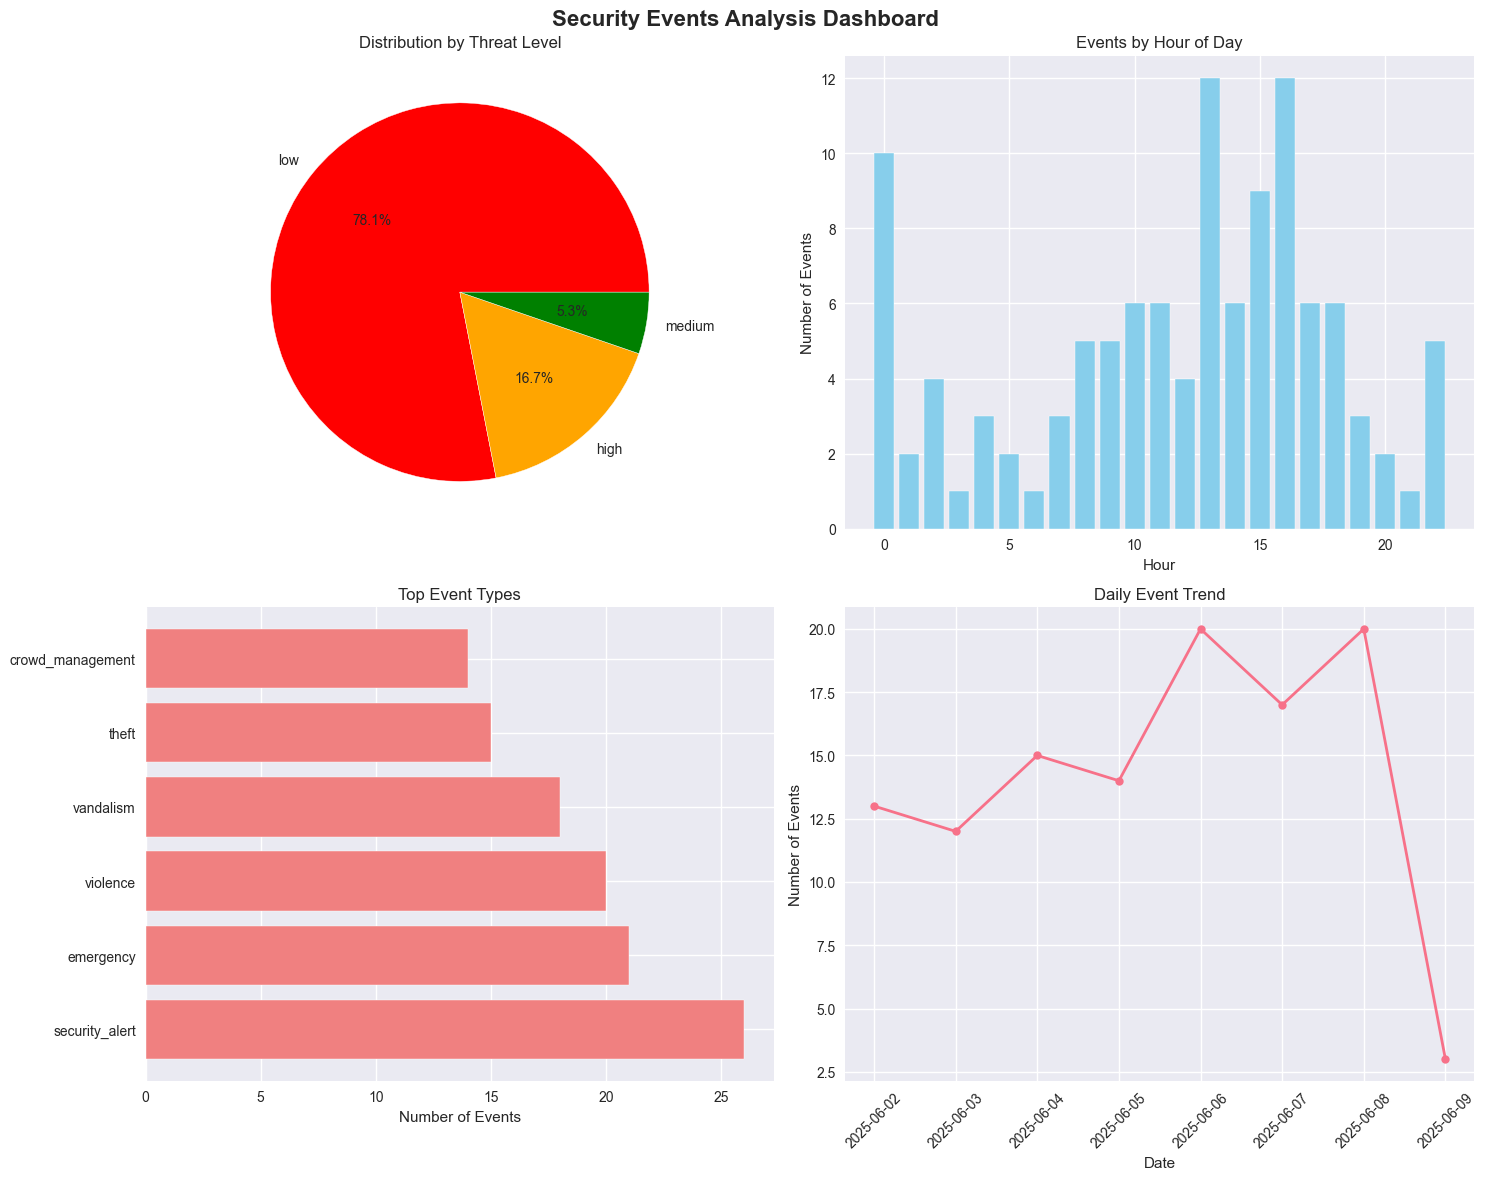


⚡ Running performance tests...
✅ NLP Report Generator system initialized!
✅ Generated 99 test events over 1 days
Events:  100 | Generation: 0.002s | Report: 0.000s | Total: 0.002s
✅ NLP Report Generator system initialized!
✅ Generated 504 test events over 1 days
Events:  500 | Generation: 0.012s | Report: 0.000s | Total: 0.012s
✅ NLP Report Generator system initialized!
✅ Generated 997 test events over 1 days
Events: 1000 | Generation: 0.024s | Report: 0.000s | Total: 0.024s
✅ NLP Report Generator system initialized!
✅ Generated 1996 test events over 1 days
Events: 2000 | Generation: 0.045s | Report: 0.000s | Total: 0.045s

🔬 Testing edge cases...
Test 1: Empty data scenario
✅ NLP Report Generator system initialized!
Empty report: No significant events recorded for today.

Test 2: Single event scenario
✅ NLP Report Generator system initialized!
Single event report:
📊 DAILY SURVEILLANCE REPORT - 2025-06-09

🎯 THREAT ASSESSMENT: 🟢 LOW RISK
📝 SUMMARY: Routine monitoring period with no si

{'total_events': 5,
 'threat_distribution': {'low': 5},
 'peak_hour': np.int64(0),
 'risk_score': np.int64(5)}

In [20]:
run_complete_test()